In [1]:
import torch

In [3]:

import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import numpy as np

In [35]:
import pandas as pd
# dataloader
class DigitsDataset(Dataset):
    """Pytorch dataloader for the Optical Recognition of Handwritten Digits Data Set"""

    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.csv_file = csv_file
        self.transform = transform
        self.df = self.load_df()

    def load_df(self):
        # read csv
        df = pd.read_csv(self.csv_file)
        return df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.df.iloc[idx, :-1] / 16
        image = np.array(image)
        image = image.astype(np.float32).reshape(8, 8)

        if self.transform:
            image = self.transform(image)
        
        image = image.reshape(-1, 64)

        # Return image and label
        return image, self.df.iloc[idx, -1]

In [42]:
image_size = 8  # Height / width of the square images
batch_size = 16

transform = transforms.Compose([transforms.ToTensor()])
dataset = DigitsDataset(csv_file="optdigits.tra.csv", transform=transform) # working only with 0
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, drop_last=True
)

0
7
4
6
2
5
5
0


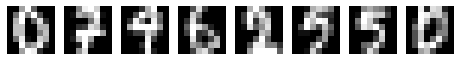

In [37]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,2))

for i in range(8):
    image = dataset[i][0].reshape(image_size,image_size)
    lab = dataset[i][1]
    print(lab)
    plt.subplot(1,8,i+1)
    plt.axis('off')
    plt.imshow(image.numpy(), cmap='gray')

plt.show()

In [16]:
len(dataset)

3822

In [49]:
class Model(nn.Module):
    """Fully connected classical discriminator"""

    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            # Inputs to first hidden layer (num_input_features -> 64)
            nn.Linear(image_size * image_size, 64),
            nn.ReLU(),
            # First hidden layer (64 -> 16)
            nn.Linear(64, 16),
            nn.ReLU(),
            # Second hidden layer (16 -> output)
            nn.Linear(16, 10),
            nn.LogSoftmax(),
        )

    def forward(self, x):
        return self.model(x)

In [19]:
lr = 0.01

In [20]:
model = Model()

opt = optim.SGD(model.parameters(), lr=0.01)

In [23]:
train_losses = []
train_counter = []

In [47]:
def train(epoch): 
  for batch_idx, (data, target) in enumerate(dataloader):
      opt.zero_grad()
      
      output = model(data)
      loss = nn.functional.nll_loss(output, target)
      loss.backward()
      opt.step()
      if batch_idx % 10 == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(dataloader.dataset),
          100. * batch_idx / len(dataloader), loss.item()))
        train_losses.append(loss.item())
        train_counter.append(
          (batch_idx*batch_size) + ((epoch-1)*len(dataloader.dataset)))
        

In [48]:
for i in range(3):
    train(i)

ValueError: Expected target size (16, 10), got torch.Size([16])